In [34]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageFont, ImageDraw
from PIL import Image
import cv2
import pytesseract
from pytesseract import Output
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import subprocess
import seaborn as sns
from collections import Counter

#### 1. Application du script à des données différentes de celles utilisées pour l'entraînement

- **Sélectionner 100 mots du dataset non-utilisés pour l'entraînement**

In [35]:
# Chemin vers le fichier texte contenant les labels et les chemins vers les images
file_path = "../../../Projet/data/12.txt"
with open(file_path, "r") as file:
    lines = file.readlines()

# Extraire les labels et les chemins vers les images
tuples = [(l.split('`')[0], l.split('`')[1].strip()) for l in lines]

# Vérification de l'existence des fichiers
result = [(f"../../../Projet/data/{item[0]}", item[1], os.path.exists(f"../../../Projet/data/{item[0]}")) for item in tuples]

# Filtrer les données existantes
data = []
for file, label, exists in result:
    if exists:
        data.append((file, label))

In [36]:
len(data)

999999

In [37]:
dataset = data[999899:999999]
len(dataset)   # 100

100

- **Ecrire un fichier csv à 2 colonnes (col1: chemin ; col2: mot)**

In [39]:
file_path = '../data/results/input.csv'

with open(file_path, mode='w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(dataset)

print(f"La liste a été enregistrée dans {file_path}")

La liste a été enregistrée dans ../data/results/input.csv


- **Appliquer le script d'OCR à chaque image de mot du csv**

In [15]:
output_file = '../data/results/output.csv'

def appliquer_script(chaine):
    result = subprocess.run(['python', 'ocr_script.py', chaine, 'word'], capture_output=True, text=True)
    return result.stdout.strip()

with open(file_path, mode='r', newline='', encoding='utf-8') as f:
    lecteur = csv.reader(f)
    donnees = list(lecteur)

for ligne in tqdm(donnees, desc="Traitement des lignes"):
    if ligne:
        ligne[0] = appliquer_script(ligne[0])

with open(output_file, mode='w', newline='', encoding='utf-8') as fichier_sortie:
    writer = csv.writer(fichier_sortie)
    writer.writerows(donnees)

print(f"Les données modifiées ont été enregistrées dans {output_file}")

Traitement des lignes: 100%|██████████| 100/100 [09:13<00:00,  5.54s/it]

Les données modifiées ont été enregistrées dans ../data/results/output.csv


In [58]:
file_path = '../data/results/input.csv'
output_file = '../data/results/output.csv'

def appliquer_script(chaine):
    result = subprocess.run(['python3', 'ocr_script.py', chaine, 'word'], capture_output=True, text=True)
    return result.stdout.strip()

with open(file_path, mode='r', newline='', encoding='utf-8') as f:
    lecteur = csv.reader(f)
    data = list(lecteur)

print(len(data))

100


In [59]:
for line in tqdm(data):
    if line:
        image_path = line[0]
        ocr_text = appliquer_script(image_path)
        line.append(ocr_text)

100%|██████████| 100/100 [10:57<00:00,  6.58s/it]


In [60]:
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(data)

print(f"Les données ont été sauvegardées dans {output_file}")

Les données ont été sauvegardées dans ../data/results/output.csv


#### 2. Evaluation

- **Taux d'erreur par mot (WER)**

In [86]:
with open(output_file, mode='r', newline='', encoding='utf-8') as f:
    lecteur = csv.reader(f)
    data = list(lecteur)

words = [[item[1], item[2]] for item in data]

In [87]:
wer = 0
for couple in words:
    if couple[0] != couple[1]:
        wer += 1
print(f"WER : {wer}%")

WER : 74%


- **Taux d'erreur par caractère (CER)**

In [88]:
# Calcul du taux d'erreur global
total_chars = 0
total_errors = 0

for couple in words:
    matches = sum(c1 == c2 for c1, c2 in zip(couple[0], couple[1]))
    total_errors += len(couple[0]) - matches
    total_chars += len(couple[0])

# Calcul du taux d'erreur global
cer = total_errors / total_chars if total_chars > 0 else 0
print(f"CER : {cer:.2%}")

CER : 40.88%


- **Visualisation des erreurs**

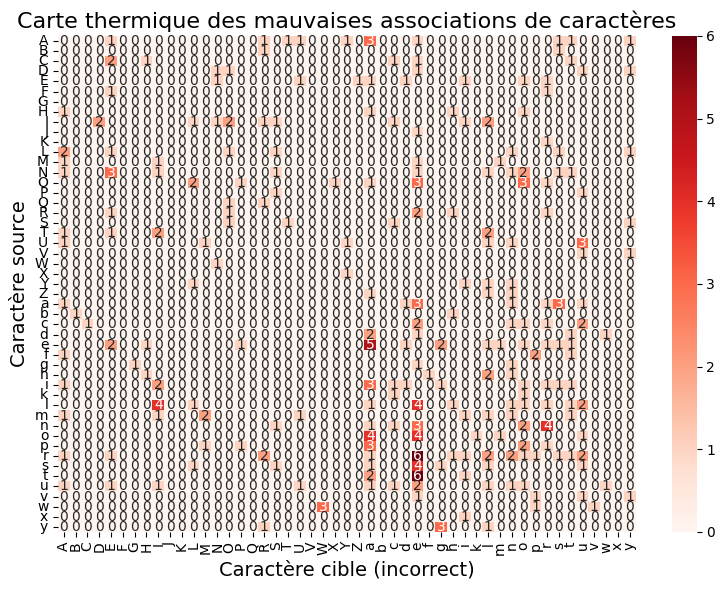

In [89]:
# Comptage des caractères mal associés
mauvais_associations = Counter()

for couple in words:
    for c1, c2 in zip(couple[0], couple[1]):
        if c1 != c2:  # Caractères qui ne correspondent pas
            mauvais_associations[(c1, c2)] += 1

# Identifier tous les caractères uniques mal associés
caracteres = sorted(set(c1 for c1, c2 in mauvais_associations.keys()) |
                    set(c2 for c1, c2 in mauvais_associations.keys()))

# Créer une matrice pour la heatmap
caractere_to_index = {c: i for i, c in enumerate(caracteres)}
matrice = np.zeros((len(caracteres), len(caracteres)))

for (c1, c2), count in mauvais_associations.items():
    i, j = caractere_to_index[c1], caractere_to_index[c2]
    matrice[i, j] = count

# Créer la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrice, annot=True, fmt=".0f", xticklabels=caracteres, yticklabels=caracteres, cmap="Reds")
plt.title("Carte thermique des mauvaises associations de caractères", fontsize=16)
plt.xlabel("Caractère cible (incorrect)", fontsize=14)
plt.ylabel("Caractère source", fontsize=14)
plt.tight_layout()

# Afficher la carte thermique
plt.show()

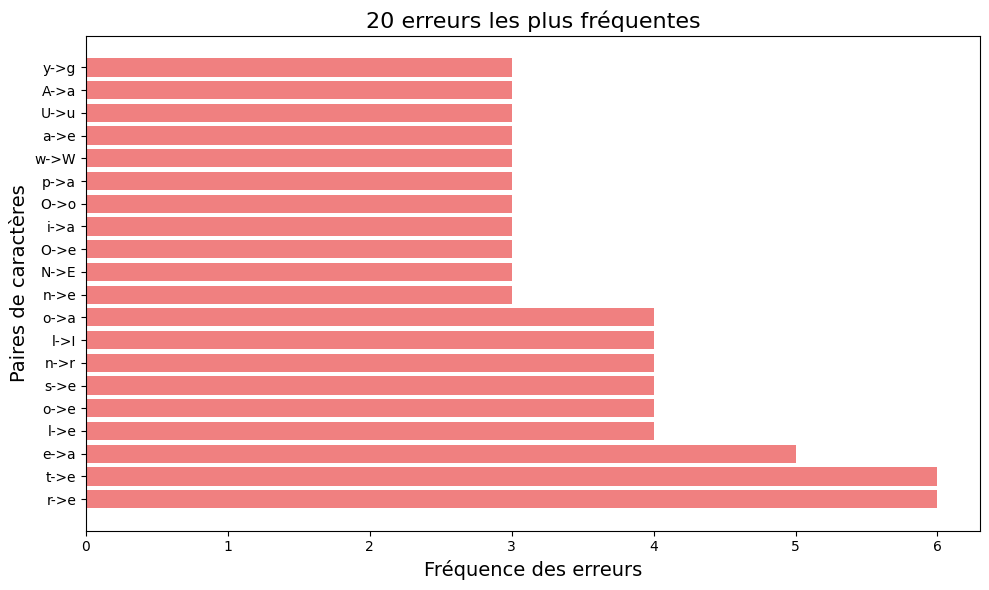

In [92]:
# Comptage des caractères mal associés
mauvais_associations = Counter()

for couple in words:
    for c1, c2 in zip(couple[0], couple[1]):
        if c1 != c2:  # Caractères qui ne correspondent pas
            mauvais_associations[(c1, c2)] += 1

# Trier les erreurs par fréquence
erreurs_triees = mauvais_associations.most_common(20)

# Séparer les données pour l'affichage
paires = [f"{c1}->{c2}" for (c1, c2), _ in erreurs_triees]
frequences = [count for _, count in erreurs_triees]

# Créer un graphique en barres pour les 20 erreurs les plus fréquentes
plt.figure(figsize=(10, 6))
plt.barh(paires, frequences, color='lightcoral')
plt.title("20 erreurs les plus fréquentes", fontsize=16)
plt.xlabel("Fréquence des erreurs", fontsize=14)
plt.ylabel("Paires de caractères", fontsize=14)
plt.tight_layout()

# Afficher le graphique
plt.show()